<a href="https://colab.research.google.com/github/linhtrinh213/Interpretable_VAE_TF_regulons/blob/main/mask_construction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Note
To work productively with gg colab (12 hours session):
1. Mount gg drive:
from google.colab import drive
drive.mount('/content/drive')
2. Then save or load files: model.save('/content/drive/MyDrive/my_model.h5')

- Export code (notebook) frequently (or save a copy in github)
- Save model checkpoints/variables...


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#### Setup ####
# install and import required packages
!pip install scanpy
!pip install decoupler
!pip install omnipath

import torch; torch.manual_seed(100)
import torch.nn as nn
import torch.utils
import torch.distributions
import torchvision
from torchvision import datasets, transforms
import math
import numpy as np
np.random.seed(100)
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
import scanpy as sc
from collections import OrderedDict
from collections import Counter

# select the right device, depending on whether your Colab runs on GPU or CPU
### IMPORTANT: we recommend to change your runtime to GPU, otherwise the training takes much longer
device = 'mps'


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 91.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 14.9 MB/s eta 0:00:00
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
   

### The data:
"Data set: For the analysis, we will use a data set that contains peripheral blood mononuclear cells (PBMCs) from systemic lupus patients, treated with Interferon beta or untreated (control). The data set is already preprocessed and is stored as an AnnData object.

An AnnData object contains the gene expression data in its .X attribute, stored as a sparse matrix. Annotations for the observations (cells) are stored in the .obs attribute, and annotations for the variables (genes) in the .var attribute. We can select specific features of the .obs or .var attribute using squared brackets, e.g. PBMC_train.obs["cell_type"] :"

In [3]:
# Load data and use Scanpy to convert it into AnnData
PBMC_train = sc.read_h5ad("/content/drive/MyDrive/WORK/Turing Project/Interpretable_VAE/data/PBMC_train.h5ad")

In [4]:
# Take a look at the data
print(PBMC_train) #the data is stored as an anndata object
print(Counter(PBMC_train.obs["cell_type"])) #summary of cell types
print(Counter(PBMC_train.obs["condition"])) #summary of conditions
# 13515 observation: cells (.obs attribute)
# gene expression data: .X (sparse matrix)
# annotations for the variables (genes) in the .var attribute
# the attribute have specific features that can be accessed using squared bracktets

AnnData object with n_obs × n_vars = 13515 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'
Counter({'CD4T': 4452, 'FCGR3A+Mono': 2881, 'CD14+Mono': 2049, 'B': 1448, 'NK': 931, 'CD8T': 892, 'Dendritic': 862})
Counter({'stimulated': 7109, 'control': 6406})


In [ ]:
PBMC_train.obs["condition"]

,condition
index,
AAATTCGACATGAC-1-control,control
TCAGTTACCTCCCA-1-control,control
GTAGTGTGTTCGTT-1-control,control
TAACACCTGTCATG-1-control,control
CAAGAAGACACTGA-1-control,control
...,...
GATCTTTGCTGTCC-1-stimulated,stimulated
ATATACGATTTGCT-1-stimulated,stimulated
GAGGGATGGTCACA-1-stimulated,stimulated


In [5]:
# devide data into control and stimulated


# Subset for a specific condition, e.g., "control"
PBMC_control = PBMC_train[PBMC_train.obs["condition"] == "control"].copy()

# Another example for "treated"
PBMC_stimulated = PBMC_train[PBMC_train.obs["condition"] == "stimulated"].copy()


In [ ]:
print(PBMC_control)


AnnData object with n_obs × n_vars = 6406 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'


In [ ]:
print(PBMC_stimulated) #dimension = number of stimulated cells


AnnData object with n_obs × n_vars = 7109 × 6998
    obs: 'condition', 'n_counts', 'n_genes', 'mt_frac', 'cell_type'
    var: 'gene_symbol', 'n_cells'
    uns: 'cell_type_colors', 'condition_colors', 'neighbors'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'


# Build a standard VAE model
- Model architecture:   
++ Encoder:
++ 2 layers, non-linear (ReLU) and fully connected NN
++ the latent space is sampled from a m
multivariate normal distribution. *In VAEs, the inputs is not encoded to fixed latent vectors, but to distribution (return a mean μ and a standard deviation sigma  σ):
z = μ + σ * ε, where ε ~ N(0, 1)*
++ dropout layers in encoder/latent space
++ *Programming: define a Pytorch nn.Module: define a class that inherits from nn.Module -> creating custon NN:
=> We can store layers as attributes: e.g. weights can be auto tracked. e.g. this layer can be called inside forward. The forward() method: define how the data flows through the layers*



In [6]:
# Define Encoder:
class Encoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout, z_dropout): #dropout between the dense layers, z_dropout define the dropout rates between the encoder/latent space
        super(Encoder, self).__init__() #run the initialize code from nn.Module -> this class behaves like a Pytorch model
        self.encoder = nn.Sequential(
                                     nn.Linear(input_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout))  #two layer, fully connected encoder with dropout

        # outputs mean vector u
        self.mu = nn.Sequential(nn.Linear(800, latent_dims), # the 800 neurons in the second layers -> latent space
                                nn.Dropout(p = z_dropout))
        # outputs standard variance
        self.sigma = nn.Sequential(nn.Linear(800, latent_dims),
                                   nn.Dropout(p = z_dropout))

        self.N = torch.distributions.Normal(0, 1)  # define Gaussian distribution for each input
        self.N.loc = self.N.loc.to(device) # move to the right device
        self.N.scale = self.N.scale.to(device)
        self.kl = 0 # place holder for storing KL divergence (regularization term)
        # KL measures how far the learned Gaussian is from the standard normal (0,1) -> this is a regularization term in VAE
    def forward(self, x):
        x = self.encoder(x) # pass the data to the encoder
        mu =  self.mu(x) # predict mean vector
        sigma = torch.exp(self.sigma(x)) # predict standard var exp for numeric stability
        z = mu + sigma*self.N.sample(mu.shape)  # Sample z using reparameterization trick

        self.kl = (0.5*sigma**2 + 0.5*mu**2 - torch.log(sigma) - 1/2).sum() #calculation of kullback-leibler divergence

        return z # output is the sampled latent vector


In [ ]:
# Define Decoder: 2 layers, non linear and fully connected

class Decoder(nn.Module):
    def __init__(self, latent_dims, input_dims, dropout):
        super(Decoder, self).__init__()
        self.decoder = nn.Sequential(
                                     nn.Linear(latent_dims, 800),
                                     nn.ReLU(),
                                     nn.Dropout(p = dropout),
                                     nn.Linear(800, input_dims)
                                     )

    def forward(self, z):
        z = self.decoder(z) # pass the latent vector through the decoder
        return z

In [ ]:
# combining Encoder and Decoder
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, input_dims,dropout = 0.3, z_dropout=0.3):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout)
        self.decoder = Decoder(latent_dims, input_dims, dropout)

    def forward(self, x):
        z = self.encoder(x) # pass data to encoder and create latent vectors
        return self.decoder(z) # returns a reconstructed version of the input

In [ ]:
# train the model:
def train(vae, data, epochs=50, beta = 0.001, learning_rate = 0.0001): # beta: scaling factor for KL term
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate) # ADAM optimizer to update model weights
    #vae.parameters(): collect all trainable parameters from the encoder and decoder
    losses = [] # store loss metrics
    klds = [] # KL divergence: regularize the latent space
    mses = [] # reconstruction lost MSE
    vae.train() #train mode (then, dropout layers are considered)

    for epoch in range(epochs):
        loss_e = 0 # start each epoch with 0 loss counters
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device) # move to GPU
            opt.zero_grad() # reset gradients
            x_hat = vae(x) # foward pass: output prediction
            mse = ((x - x_hat)**2).sum() # x_hat: reconstructed input -> calculated reconstruction loss
            kld = beta* vae.encoder.kl # KL divergence ensures latent space is close to normal distribution (beta controls the strength of KL penalty)
            loss = mse +  kld # loss calculation : TOTAL loss
            loss.backward() # backpropagate gradients
            opt.step() # UPDATE weights
            loss_e += loss.to('cpu').detach().numpy() # move values to CPU and save em
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()

        losses.append(loss_e/(len(data)*128)) # normalize per sample(batch size = 128)
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128)) # returns a list of losses after each epoch

    return vae, losses, klds, mses # returned the trained model

In [ ]:
PBMC_trainX = torch.utils.data.DataLoader(PBMC_train.X.toarray(), batch_size=128) #set up the training data in the right format
# training data (gene expression data)
latent_dims = 50 #choose the number of latent variables

In [ ]:
import torch
# NOTE: In Runtime, Change type (hardware accelerator) -> GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# initialize VAE and use PBMC data to train the model
vae = VariationalAutoencoder(latent_dims = latent_dims, input_dims = PBMC_train.shape[1]).to(device)
vae, losses, klds, mses = train(vae, PBMC_trainX, beta = 0.001) #takes about 1 min on GPU

epoch:  0  loss:  469.133
epoch:  1  loss:  334.93008
epoch:  2  loss:  295.03076
epoch:  3  loss:  269.53415
epoch:  4  loss:  250.16924
epoch:  5  loss:  235.86983
epoch:  6  loss:  225.20613
epoch:  7  loss:  216.53853
epoch:  8  loss:  208.60017
epoch:  9  loss:  202.16495


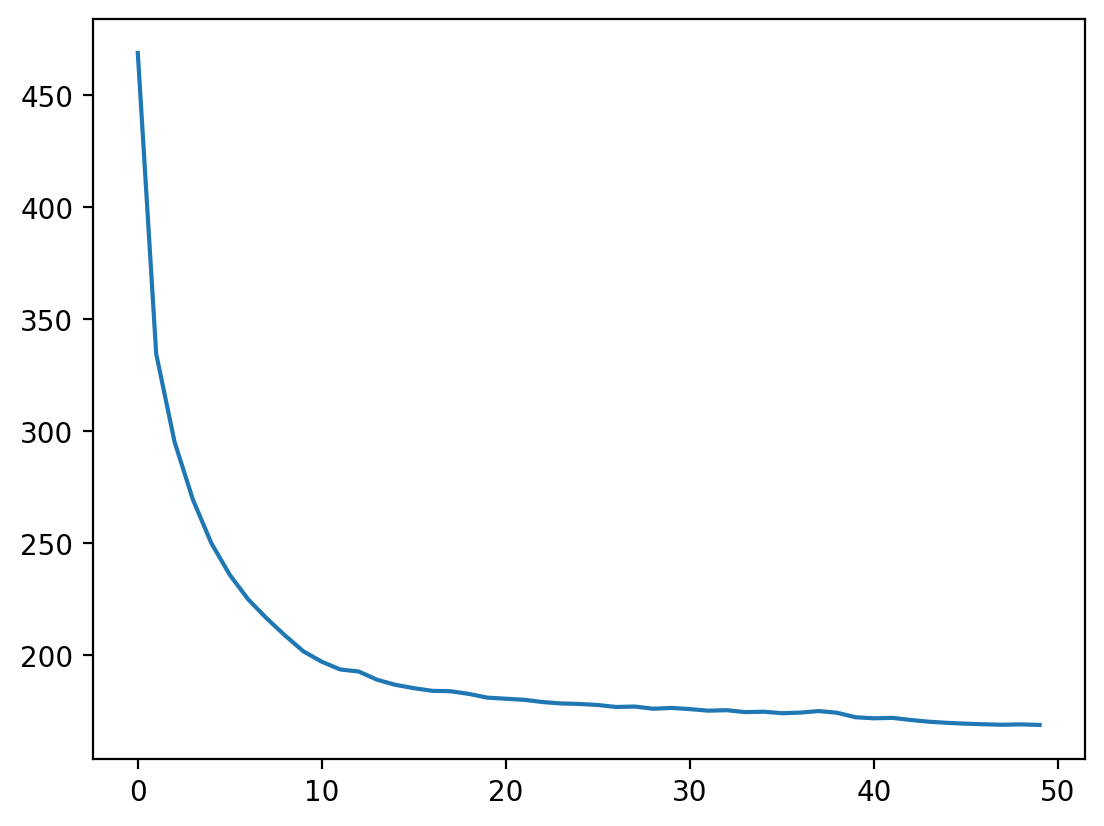

In [ ]:
# plot and loss curve to see if it converges
plt.plot(losses)

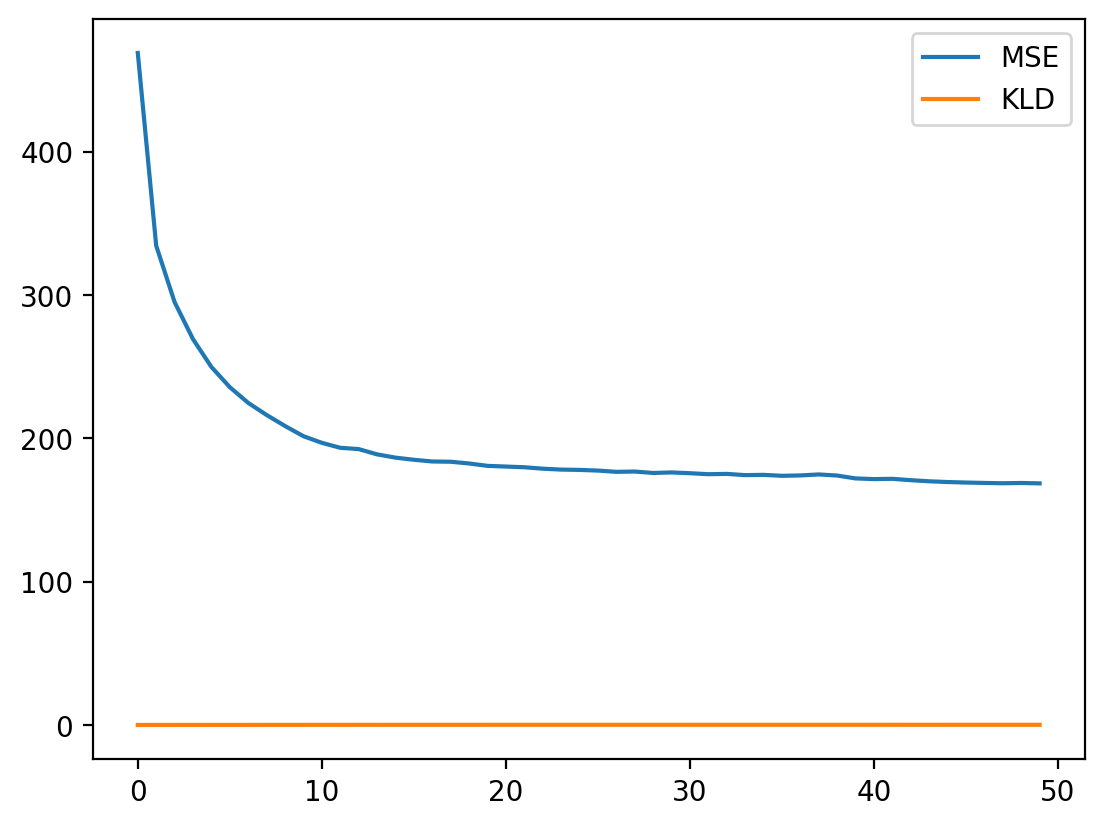

In [ ]:
# plot MSE and KLD
plt.plot(mses, label = "MSE")
plt.plot(klds, label = "KLD")
plt.legend()

In [ ]:
# project the data to the latent space, and store this in the Anndata object
def to_latent(vae, adata): # vae: the trained variational autoencoder
        latent = []
        data = torch.tensor(adata.X.toarray()).to(device) # adata.X: sparse matrix -> convert to numpy dense array -> pytorch tensor and moved to GPU
        vae.eval() # we need to set the model to evaluation mode, so that the dropout is no longer considered
        z = vae.encoder(data) #
        latent += [z.to("cpu")]
        return torch.cat(latent).detach().numpy()

PBMC_train.obsm["latent_embedding"] = to_latent(vae, PBMC_train)

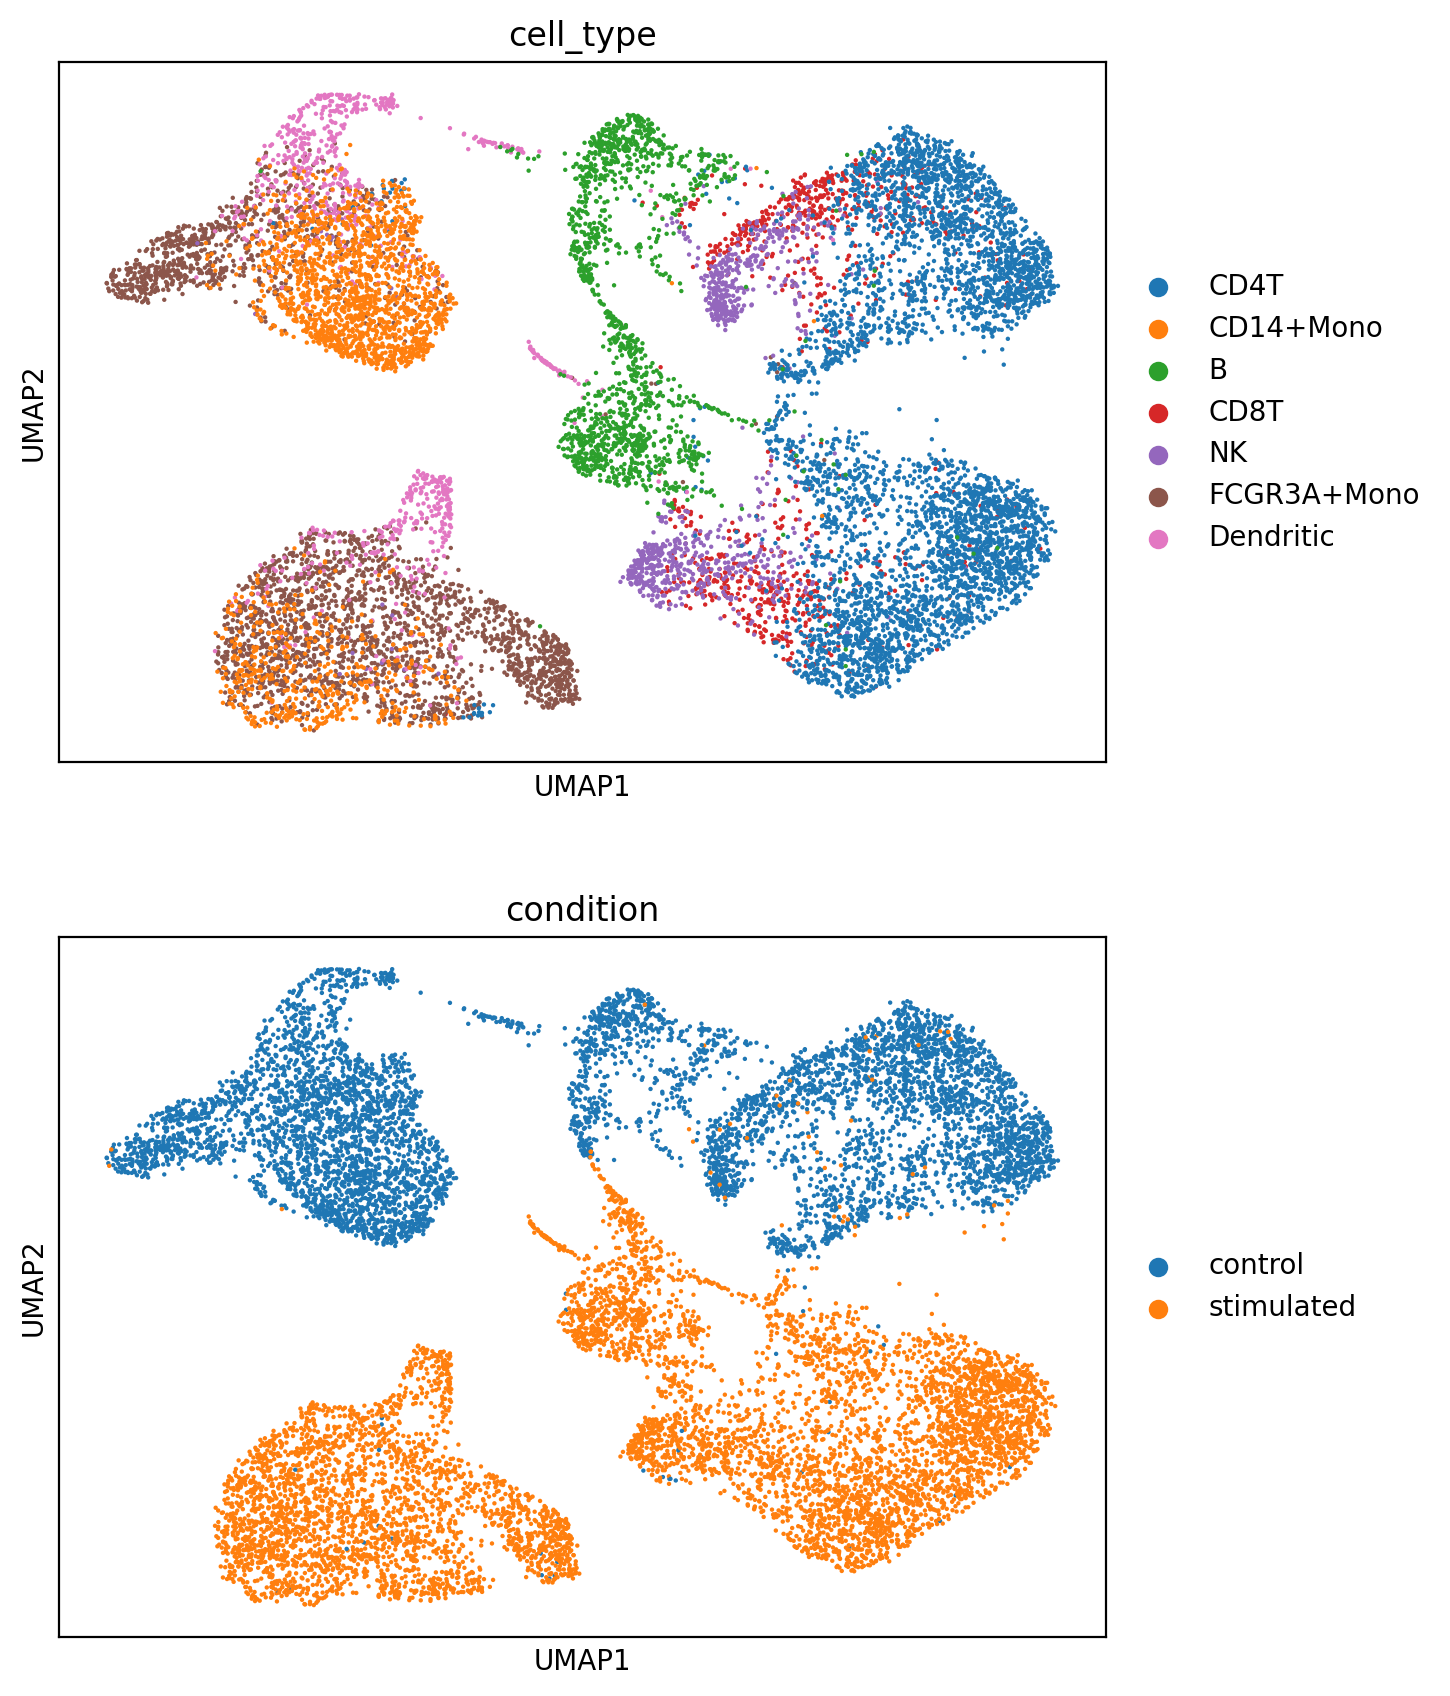

In [ ]:
# Visualizing the cell embedding in the latent space using UMAP
sc.pp.neighbors(PBMC_train, use_rep='latent_embedding', n_neighbors=15) # use_rep specifies that the calculation is based on the latent embedding
sc.tl.umap(PBMC_train, random_state=1) #set random state to ensure reproducibility
sc.pl.umap(PBMC_train, color=["cell_type", "condition"], size=10, ncols = 1)

###Note:
could change hyperparameters: latent_dim, beta, number of nodes, number of layers, ...

- train 2 separate models: one for condition, one for treatment
-  TF regulons from collecTRI database (filter the regulons based on regulon size prior to incorporation into the model) => create biologically interpretable VAEs first

# Biologically interpretable VAEs


To achieve interpretability through model's decoder:
1. one-layer decoder: every latent var is directly connected to the output var
2. linear decoder: no activation function in the decoder
3. positive decoder: restrict the decoder weights to positive values (all negative weights = 0) (*why not - weight?, cant it be for inhibition?)
=> for this project: TF: It can be negative!
4. sparse decoder: latent node = TF, which only connect to certain genes


- How do we do that?
++ mask M: define decoder connections. Rows = genes. Columns = TF. If TF j has an effect on gene i -> the corresponding entry in the matrix M(i,j) contains the value 1. ??: has an effect = activate AND inhibit, or only activate?
So mask M: only defines which latent node **connect** to which decoder node, and the weights will learn + or - (activation or inhibition, or at least thats what we expect).
++ mask M: also includes fully connected nodes (all values = 1) -> for better data reconstruction and compensates for connections that are missing

In [8]:
# processed regulons
#import decoupler as dc
regulons = dc.get_collectri(organism='human', split_complexes=False)
# CollecTRI network: a curated collection of TFs and their transcriptional targets
# spilt_complexes: keep or spilt complexes into subunits
# weight: 1 is activation. -1 is inhibition
# raw regulons
#import omnipath as op
#op.interactions.CollecTRI.get(genesymbols=True, organism=9606L, loops=True)#

In [10]:
# Create the mask
# 1. Get unique genes (targets) and TFs (sources)
import pandas as pd
genes = regulons['target'].unique()
tfs = regulons['source'].unique()

# 2. Initialize matrix M with zeros
M = pd.DataFrame(0, index=genes, columns=tfs)

# 3. Set M[i,j] = 1 where the gene i is affected by TF j
for _, row in regulons.iterrows(): # for each row in regulons
    M.loc[row['target'], row['source']] = 1 #the corresponding genes, TF box = 1

In [11]:
print(M) # 6627 genes, 1163 TFs

         ABL1  ADNP  ADNP2  AEBP1  AEBP2  AHR  AHRR  AIP  AIRE  AKNA  ...  \
BAX         1     0      0      0      0    1     0    0     0     0  ...   
BCL2        1     0      0      0      0    0     0    0     0     0  ...   
BCL6        1     0      0      0      0    0     0    0     0     0  ...   
CCND2       1     0      0      0      0    0     0    0     0     0  ...   
CDKN1A      1     0      0      0      0    1     0    0     0     0  ...   
...       ...   ...    ...    ...    ...  ...   ...  ...   ...   ...  ...   
MAGI2       0     0      0      0      0    0     0    0     0     0  ...   
REC114      0     0      0      0      0    0     0    0     0     0  ...   
SYNJ1       0     0      0      0      0    0     0    0     0     0  ...   
TCP11       0     0      0      0      0    0     0    0     0     0  ...   
PIK3AP1     0     0      0      0      0    0     0    0     0     0  ...   

         ZNF804A  ZNF85  ZNF91  ZSCAN10  ZSCAN18  ZSCAN21  ZSCAN26  ZSCAN9 

In [ ]:
import numpy as np
  # Add unannotated nodes
    vec = np.ones((M.shape[0], add_nodes))
    mask = np.hstack((mask, vec))

    adata.uns['_vega'] = dict() #create attribute "_vega" to store the mask and pathway information
    adata.uns['_vega']['mask'] = mask
    adata.uns['_vega']['gmv_names'] = list(gmv_dict.keys()) + ['UNANNOTATED_'+str(k) for k in range(add_nodes)]


In [16]:
####### In the following sections, we used and adapted code from https://github.com/LucasESBS/vega ######
import pandas as pd
import numpy as np

def create_mask(adata, regulons, add_nodes:int=10, sep = "\t"):
    """
    Initialize mask M that specifies which latent nodes connect to which decoder nodes.
    Args:
        adata (Anndata): Scanpy single-cell object, we will store the computed mask and the names of the biological processes there
        regulons: which TFs affected which genes
        add_nodes (int): Additional latent nodes for capturing additional variance
    Return:
        adata (Anndata): Scanpy single-cell object that now stores the computed mask and the names of biological processes (in the .uns["_vega"] attribute)
        mask (array): mask M that specifies whether a gene is included in the gene set of a pathway (value one) or not (value zero)
    """

    # Create the mask
    # 1. Get unique genes (targets) and TFs (sources)
    genes = regulons['target'].unique()
    tfs = regulons['source'].unique()

    # 2. Initialize matrix M with zeros
    M = pd.DataFrame(0, index=genes, columns=tfs)

    # 3. Set M[i,j] = 1 where the gene i is affected by TF j
    for _, row in regulons.iterrows(): # for each row in regulons
        M.loc[row['target'], row['source']] = 1 #the corresponding genes, TF box = 1


    # Add unannotated nodes
    vec = np.ones((M.shape[0], add_nodes))
    M = np.hstack((M, vec))

    adata.uns['_vega'] = dict() #create attribute "_vega" to store the mask and pathway information
    adata.uns['_vega']['mask'] = M
    adata.uns['_vega']['TFs'] = list(tfs) + ['UNANNOTATED_'+str(k) for k in range(add_nodes)]


    return adata, M

In [20]:
PBMC_train, mask = create_mask(PBMC_train,regulons , add_nodes=1)

In [23]:
mask.shape[1]

1164

In [24]:
# define VEGA's decoder (which is adapted to enable biologcal intepretability )

class DecoderVEGA(nn.Module):
  """
  Define VEGA's decoder (sparse, one-layer, linear)
  """
  def __init__(self, mask):
        super(DecoderVEGA, self).__init__()

        self.sparse_layer = nn.Sequential(SparseLayer(mask)) # we define the architecture of the decoder below with the class "SparseLayer"

  def forward(self, x):
    z = self.sparse_layer(x.to(device)) # pass the latent representation x -> predict gene expression z
    return(z)

 # def positive_weights(self): because here we do wanna have neg weights (?)
  #    """
   #   constrain the decoder to positive weights (set negative weigths to zero)
    #  """
     # w = self.sparse_layer[0].weight
      #w.data = w.data.clamp(0)
      #return w


# define a class SparseLayer, that specifies the decoder architecture (sparse connections based on the mask)
class SparseLayer(nn.Module):
  def __init__(self, mask):
        """
        Extended torch.nn module which mask connection
        """
        super(SparseLayer, self).__init__()

        self.mask = nn.Parameter(torch.tensor(mask, dtype=torch.float).t(), requires_grad=False) # mask: binary matrix of shape (genes, TFs) — entry (i, j) = 1 if TF j regulates gene i.
        self.weight = nn.Parameter(torch.Tensor(mask.shape[1], mask.shape[0])) # mask dimension: in our cases 1164, 6627 ()
        self.bias = nn.Parameter(torch.Tensor(mask.shape[1])) #there should be in total 1164 nodes aka TF in the latent space -> hence 1164 biases
        self.reset_parameters()

        # mask weight
        self.weight.data = self.weight.data * self.mask # All connections not allowed by the mask are zeroed out

  def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1)) #
        self.weight.data.uniform_(-stdv, stdv)
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input):
        # See the autograd section for explanation of what happens here
        return SparseLayerFunction.apply(input, self.weight, self.bias, self.mask)


######### You don't need to understand this part of the code in detail #########
# SparseLayerFunction: Custom gradient-aware layer to apply the mask during both forward and backward passes
class SparseLayerFunction(torch.autograd.Function):
    """
    We define our own autograd function which masks it's weights by 'mask'.
    For more details, see https://pytorch.org/docs/stable/notes/extending.html
    """

    # Note that both forward and backward are @staticmethods
    @staticmethod
    def forward(ctx, input, weight, bias, mask):

        weight = weight * mask # change weight to 0 where mask == 0
        #calculate the output
        output = input.mm(weight.t())
        output += bias.unsqueeze(0).expand_as(output) # Add bias to all values in output
        ctx.save_for_backward(input, weight, bias, mask)
        return output

    @staticmethod
    def backward(ctx, grad_output): # define the gradient formula
        input, weight, bias, mask = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = grad_mask = None

        # These needs_input_grad checks are optional and only to improve efficiency
        if ctx.needs_input_grad[0]:
            grad_input = grad_output.mm(weight)
        if ctx.needs_input_grad[1]:
            grad_weight = grad_output.t().mm(input)
            # change grad_weight to 0 where mask == 0
            grad_weight = grad_weight * mask
        if ctx.needs_input_grad[2]:
            grad_bias = grad_output.sum(0).squeeze(0)

        return grad_input, grad_weight, grad_bias, grad_mask


In [26]:
class VEGA(nn.Module):
    def __init__(self, latent_dims, input_dims, mask, dropout = 0.3, z_dropout = 0.3):
        super(VEGA, self).__init__()
        self.encoder = Encoder(latent_dims, input_dims, dropout, z_dropout) # we use the same encoder as before (two-layer, fully connected, non-linear)
        self.decoder = DecoderVEGA(mask)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [25]:
#training loop
def trainVEGA(vae, data, epochs=50, beta = 0.0001, learning_rate = 0.001):
    opt = torch.optim.Adam(vae.parameters(), lr = learning_rate, weight_decay = 5e-4)
    vae.train() #train mode
    losses = []
    klds = []
    mses = []

    for epoch in range(epochs):
        loss_e = 0
        kld_e = 0
        mse_e = 0

        for x in data:
            x = x.to(device)
            opt.zero_grad()
            x_hat = vae(x)
            mse = ((x - x_hat)**2).sum()
            kld = beta* vae.encoder.kl
            loss = mse +  kld # loss calculation
            loss.backward()
            opt.step()
            loss_e += loss.to('cpu').detach().numpy()
            kld_e += kld.to('cpu').detach().numpy()
            mse_e += mse.to('cpu').detach().numpy()
            vae.decoder.positive_weights() # we restrict the decoder for positive weights

        losses.append(loss_e/(len(data)*128))
        klds.append(kld_e/(len(data)*128))
        mses.append(mse_e/(len(data)*128))

        print("epoch: ", epoch, " loss: ", loss_e/(len(data)*128))

    return vae, losses, klds, mses

In [28]:
import torch
# NOTE: In Runtime, Change type (hardware accelerator) -> GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [30]:
# devide data into control and stimulated


# Subset for a specific condition, e.g., "control"
PBMC_control = PBMC_train[PBMC_train.obs["condition"] == "control"].copy()

# Another example for "treated"
PBMC_stimulated = PBMC_train[PBMC_train.obs["condition"] == "stimulated"].copy()


In [31]:
# train the model for control
PBMC_controlX = torch.utils.data.DataLoader(PBMC_control.X.toarray(), batch_size=128) #set up the training data in the right format
PBMC_stimulatedX = torch.utils.data.DataLoader(PBMC_stimulated.X.toarray(), batch_size=128) #set up the training data in the right format

# training data (gene expression data)
latent_dims = 50 #choose the number of latent variables


In [32]:
# train the model for control
vega_ctr = VEGA(latent_dims= mask.shape[1], input_dims = PBMC_control.shape[0], mask = mask.T, z_dropout = 0.5, dropout = 0.3).to(device)
# model training
vega_ctr, vega_losses_ctr, vega_klds_ctr, vega_mses_ctr = trainVEGA(vega_ctr, PBMC_controlX,epochs = 50, beta = 0.0001) #takes about 2 mins on GPU

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x6998 and 6627x800)

In [37]:
PBMC_control.shape[1]

6998